# Here's [link](https://github.com/Julfyy/Julfyy-Coursera-DL-course) to GitHub with all code

**Histopathologic Cancer Detection**

In this competition, I must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

**Dataset**

The dataset contains lots of images, that are the small parts of different pathology scans.


**What we need to do?**
For each id in the test set, you must predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue. The file should contain a header and have the following format:

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
etc.

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import * 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Read all data from train_label.csv and change id to file name.**

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [4]:
!kaggle competitions download -c histopathologic-cancer-detection


100% 6.29G/6.31G [02:37<00:00, 31.3MB/s]
100% 6.31G/6.31G [02:37<00:00, 42.9MB/s]


In [ ]:
!unzip histopathologic-cancer-detection.zip

In [6]:
train_data_full = pd.read_csv('../content//train_labels.csv', dtype=str)
print("Shape of dataset: ",train_data_full.shape)

train_data_full.id = train_data_full.id + '.tif'
train_data_full.head()

Shape of dataset:  (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [7]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**For some statistics, lets see label distribution**

In [8]:
(train_data_full.label.value_counts() / len(train_data_full)).to_frame().sort_index().T

,0,1
label,0.594969,0.405031


**Lets see some data images example:**

Dataset image example


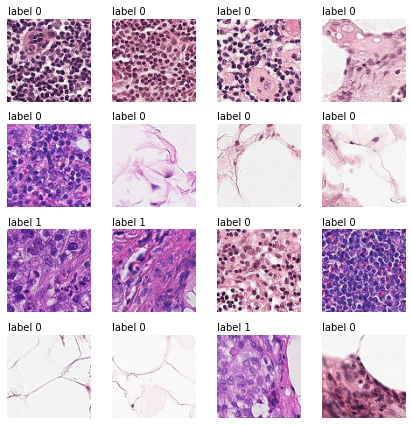

In [9]:
print("Dataset image example")
h_path = '/content/train'
sample = train_data_full.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():
    img = mpimg.imread(f'/content/train/{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0,-5,f'label {label}', color='k')

    plt.axis('off')

plt.tight_layout()
plt.show()


# Exploratory Data Analysis (EDA).

And also creation of data loaders for training and validation.

In [10]:
# Divide into training and validation part
train_data, valid_data = train_test_split(train_data_full, test_size=0.2, random_state=1, stratify=train_data_full.label)

# Data loaders
train_data_gen = ImageDataGenerator(rescale=1/255)
validation_data_gen = ImageDataGenerator(rescale=1/255)

BATCH_SIZE = 64

train_loader = train_data_gen.flow_from_dataframe(
    dataframe = train_data,
    directory = h_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = train_data_gen.flow_from_dataframe(
    dataframe = valid_data,
    directory = h_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# **Model Architecture**
(Set log level becouse of warning from kaggle)

**Input shape** is 96px x 96px x 3 (because of rgb)

**I'll use 3 blocks, each containing:**
* 2 conv2d layers, 
* max pooling (2x2) layer, 
* dropout and batch normalization. 
* Activation function - relu, padding - same.

**Then the Flatten layer**

**Then layers for clasification:**
* Dense 64 layer + dropout (activation - relu)
* Dense 8 layer + dropout (activation - relu)
* Batch normalization
* Output layer - dense 2 with sigmoid activation (optimal for binary classification)

In [11]:
# Build CNN
np.random.seed(1)
tf.random.set_seed(1)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
cnn = Sequential([
    Conv2D(64, (3,3), activation = 'relu', padding = 'same', input_shape=(96,96,3)),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='sigmoid')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        3

# Setting optimizer parameter for the first training



In [12]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

# Function to visualize training results

In [ ]:
def show_res():
    epoch_range = range(1, len(history['loss'])+1)

    plt.figure(figsize=[14,4])
    plt.subplot(1,3,1)
    plt.plot(epoch_range, history['loss'], label='Training')
    plt.plot(epoch_range, history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epoch_range, history['accuracy'], label='Training')
    plt.plot(epoch_range, history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    #plt.subplot(1,3,3)
    #plt.plot(epoch_range, history['auc_1'], label='Training')
    #plt.plot(epoch_range, history['val_auc_1'], label='Validation')
    #plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
    #plt.legend()
    plt.tight_layout()
    plt.show()
    


Let's set learning rate to 0.001.

For not overfitting our model let's do 20 *epochs*

In [14]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.001)

In [ ]:
%%time 

h1 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = len(train_loader), 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = len(valid_loader), 
    verbose = 1
)

In [ ]:
for k in history.keys():
    history[k] += h1.history[k]
show_res()

We have a bad results on the Validation set

So, probably, that is caused by learning rate - it is too big. In the next try I'll change it to the less one.

Also our model is probably be overfitted, so I'll also reduce epochs number to 10

In [16]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)

In [17]:
%%time 

h2 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = len(train_loader), 
    epochs = 10,
    validation_data = valid_loader, 
    validation_steps = len(valid_loader), 
    verbose = 1
)

Epoch 1/10
2751/2751 [==============================] - 368s 134ms/step - loss: 0.4455 - accuracy: 0.8167 - auc: 0.8071 - val_loss: 1.3344 - val_accuracy: 0.4066 - val_auc: 0.5929
Epoch 2/10
2751/2751 [==============================] - 310s 113ms/step - loss: 0.4094 - accuracy: 0.8348 - auc: 0.8429 - val_loss: 0.8556 - val_accuracy: 0.4362 - val_auc: 0.5298
Epoch 3/10
2751/2751 [==============================] - 294s 107ms/step - loss: 0.3736 - accuracy: 0.8532 - auc: 0.8782 - val_loss: 1.1923 - val_accuracy: 0.5079 - val_auc: 0.5982
Epoch 4/10
2751/2751 [==============================] - 296s 107ms/step - loss: 0.3454 - accuracy: 0.8672 - auc: 0.9017 - val_loss: 1.8772 - val_accuracy: 0.5648 - val_auc: 0.6241
Epoch 5/10
2751/2751 [==============================] - 289s 105ms/step - loss: 0.3291 - accuracy: 0.8746 - auc: 0.9148 - val_loss: 0.7338 - val_accuracy: 0.5980 - val_auc: 0.7292
Epoch 6/10
2751/2751 [==============================] - 284s 103ms/step - loss: 0.3137 - accuracy: 0

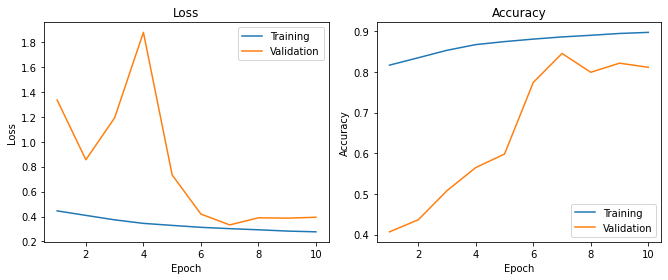

In [40]:
history += h2.history

show_res()

**So, as we can see, the accuracy is  good (around 0.8 for validation set).**

That would be enough

# Submission
**Firstly we need to read all data from test folder**

And look some sample from it.


In [43]:
test_data = pd.read_csv('/content/sample_submission.csv')
print('Test data has ', test_data.shape, ' size.')
test_data['file_n'] = test_data.id + '.tif'
test_data.head()

Test data has  (57458, 2)  size.


,id,label,file_n
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [51]:
BATCH_SIZE = 64

test_data_gen = ImageDataGenerator(rescale=1/255)

test_loader = test_data_gen.flow_from_dataframe(
    dataframe = test_data,
    directory = "/content/test/",
    x_col = 'file_n',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


**Start prediction and get size of result**

In [52]:
test_end = cnn.predict(test_loader)
print(test_end.shape)

(57458, 2)


In [54]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


**lets fit our ansver to competition submission form**

In [55]:
submission.label = test_end[:,1]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.279700
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.747463
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.224626
3,2c35657e312966e9294eac6841726ff3a748febf,0.358976
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.136764


In [56]:
submission.to_csv('submission.csv', header=True, index=False)